In [3]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
import matplotlib
import matplotlib.pyplot as plt
#import pyart
#from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
#import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_rh, dry_lapse, moist_lapse, vapor_pressure, saturation_vapor_pressure,
                        wind_speed, wind_direction, pressure_to_height_std, mixing_ratio, cape_cin, wind_components,
                        height_to_pressure_std, equivalent_potential_temperature, parcel_profile, precipitable_water,
                        storm_relative_helicity, mean_pressure_weighted, most_unstable_cape_cin, most_unstable_parcel,
                        supercell_composite, significant_tornado, get_layer, relative_humidity_from_dewpoint)
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.calc import wind_direction
from metpy.units import units
from metpy.calc import lcl
from metpy.interpolate import interpolate_1d as metinterp
from metpy.interpolate import log_interpolate_1d
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from metpy.plots import SkewT
from metpy.plots import Hodograph
import metpy.calc as metcalc

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv

In [232]:
#for KLCH missing case, lat=29.758, lon =-93.556, time=23z

#Enter in the info you'll need to get a sounding
#(the radar site, tor/nontor, date and time, and lat/lon)
site = 'KLCH'
tor_nontor = 'T'
year=2020
month=5
day=17
hour=23

cenlat = 29.758
cenlon = -93.556

#Don't change below here
#########################################
time_start = datetime(year, month, day, hour, 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)

In [233]:
#Link for RAP analysis dataset
#Link for cases after 5/15/20
cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#Old case link
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#Try 20 km
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')

#Have a link for the 20km RAP grid
#cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#And a link for the RUC analysis grids
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#Link to 20km RUC
#cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')

#cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
latest_ds = list(cat.datasets.values())[0]
print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('Convective_available_potential_energy_surface').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Storm_relative_helicity_height_above_ground_layer').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear_height_above_ground_layer').variables('Vertical_v-component_shear_height_above_ground_layer').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric').variables('MSLP_MAPS_System_Reduction_msl')
query.add_lonlat().lonlat_box(cenlon-2.1, cenlon +2.1, cenlat-2.1, cenlat+2.1)
data1 = ncss.get_data(query)
dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2]
dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3]
CAPE = np.asarray(data1.variables['Convective_available_potential_energy_surface'][:]) * units('J/kg')
SRH = np.asarray(data1.variables['Storm_relative_helicity_height_above_ground_layer'][:]) * units('m/s')
SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin')).to('degC')
T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
#ushr = data1.variables['Vertical_u-component_shear_height_above_ground_layer'][:] * units('m/s')
#vshr = data1.variables['Vertical_v-component_shear_height_above_ground_layer'][:] * units('m/s')
hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
MSLP = (np.asarray(data1.variables['MSLP_MAPS_System_Reduction_msl'][:])/100.) * units('hPa')
# Get the dimension data
lats_r = data1.variables[dlat][:]
lons_r= data1.variables[dlon][:]
lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

flon = float(cenlon)
flat = float(cenlat)
# Set up our array of latitude and longitude values and transform to 
# the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]
dlon = np.abs(trlons - cenlon)
dlat = np.abs(trlats - cenlat)
ilon = np.where(dlon == np.min(dlon))
ilat = np.where(dlat == np.min(dlat))

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\siphon\catalog.py:267: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/202005/20200517/catalog.html?dataset=rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/202005/20200517/catalog.xml?dataset=rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


{'OPENDAP': 'https://www.ncei.noaa.gov/thredds/dodsC/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'HTTPServer': 'https://www.ncei.noaa.gov/thredds/fileServer/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'WCS': 'https://www.ncei.noaa.gov/thredds/wcs/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'WMS': 'https://www.ncei.noaa.gov/thredds/wms/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'NetcdfSubset': 'https://www.ncei.noaa.gov/thredds/ncss/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'NCML': 'https://www.ncei.noaa.gov/thredds/ncml/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'UDDC': 'https://www.ncei.noaa.gov/thredds/uddc/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2', 'ISO': 'https://www.ncei.noaa.gov/thredds/iso/model-rap130anl/202005/20200517/rap_130_20200517_2300_000.grb2'}


In [234]:
RH_prof = RH_up[0,:,ilat[0][0], ilon[1][0]]
Tdc_up = dewpoint_rh(Temp_up[0,:,ilat[0][0], ilon[1][0]],RH_up[0,:,ilat[0][0], ilon[1][0]]/100)
Omega = VVEL_up[0,:,ilat[0][0], ilon[1][0]]

p_sounding = np.sort(np.append(lev, SFCP[0,ilat[0][0], ilon[1][0]]))
ind = np.where(p_sounding >= SFCP[0,ilat[0][0], ilon[1][0]])[0][0]
hgt_sounding = np.insert(hgt[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, sfc_hgt[0,ilat[0][0], ilon[1][0]].magnitude) * hgt.units
T_sounding = (np.insert(Temp_up[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, T[0,0,ilat[0][0], ilon[1][0]].magnitude) * T.units).to(Tdc_up.units)
Td_sounding = np.insert(Tdc_up.magnitude, ind, Td[0,0,ilat[0][0], ilon[1][0]].magnitude) * Tdc_up.units
u_sounding = np.insert(uwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, usfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
v_sounding = np.insert(vwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, vsfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units

p_skewt = p_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
hgt_skewt = hgt_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
T_skewt = T_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
Td_skewt = Td_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
u_skewt = u_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]].to('kt')
v_skewt = v_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]].to('kt')
storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])

#Get RH for whole sounding
RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\metpy\xarray.py:677: MetpyDeprecationWarning: The dewpoint_rh function was deprecated in version 0.12. This function has been renamed dewpoint_from_relative_humidity.
  return func(*args, **kwargs)


In [235]:
#wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
wind_dir = []
for i in range(len(u_skewt)):
    wdir = wind_direction(u_skewt[i], v_skewt[i])
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = wind_speed(u_skewt, v_skewt)

In [236]:
prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)

In [237]:
#Storm motion with 2014 Bunkers values
srwind = params.bunkers_storm_motion(prof)
print("Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1]))
print("Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3]))

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=357.7675378796329,
             mask=False,
       fill_value=-9999.0), 19.36103530751296)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=298.2797689759707,
             mask=False,
       fill_value=-9999.0), 33.745491659532576)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\numpy\lib\function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


In [238]:
sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
#fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

In [239]:
#This cell calculates and prints out a bunch of parameters
#You'll need the freezing level, which is printed out below
#as 
###############################################################
#Get MU and ML CAPE
mlcape = mlpcl.bplus
mucape = mupcl.bplus
#Get sfc-based lfc height
lfc = mlpcl.lfchght
#Get cin
cin = mlpcl.bminus
#Get parameters to match previous data
sfc = prof.pres[prof.sfc]

p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
p9km = interp.pres(prof, interp.to_msl(prof, 9000.))

srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]

#Get shear magnitudes
sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
sfc1shear = utils.mag( sfc_1km_shear[0], sfc_1km_shear[1] )
sfc3shear = utils.mag( sfc_3km_shear[0], sfc_3km_shear[1] )
sfc6shear = utils.mag( sfc_6km_shear[0], sfc_6km_shear[1] )

#Use MetPy to get the RH interpolations and pressure-weighted layers
mpwrh_13 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], bottom=1000*units('meter'), depth=2000 * units.meter)[0].magnitude
mpwrh_36 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], bottom=3000*units('meter'), depth=3000 * units.meter)[0].magnitude
mpwrh_69 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], heights=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
#mpwrh_69 = np.nan
#Use MetPy to interpolate to the 3, 6, and 9km levels
rh3 = metinterp(3000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
rh6 = metinterp(6000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
rh9 = metinterp(9000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude

#Get 0C height from SharpPy
hgt0c = sfcpcl.hght0c
#Get convective temp
ctemp = params.convective_temp(prof)
#Add to a new profile and get the lcl from that (which becomes the ccl)
T_skewt_c = np.copy(T_skewt.magnitude)
T_skewt_c[-1] = ctemp
profc = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt_c[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
sfcpclc = params.parcelx( profc, flag=1 ) # Surface Parcel for ccl
ccl = mlpcl.lclhght
#Interpolate temperature to the ccl height with MetPy
cclt = metinterp(ccl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

#Get normal lcl height and t
lcl = mlpcl.lclhght
lclt = metinterp(lcl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

#Get sigtor
sigtor = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km, utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])

#Get effective inflow stuff
eff_inflow = params.effective_inflow_layer(prof)
ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])[0]
ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
ebwspd = utils.mag( ebwd[0], ebwd[1] )

#Get suepercell composite
scp = params.scp(mupcl.bplus, effective_srh, ebwspd)
#Get EHI
EHI = params.ehi(prof, sfcpcl, sfc, 3000, stu = srwind[0], stv = srwind[1])

print("MLCAPE", mlcape)
print('lcl z', lcl)
print('lfc z', lfc)
print('MUCAPE', mucape)
print('cin', cin)
print("ESRH", effective_srh)
print('ESHR', ebwspd)
print("scp", scp)
print('sigtor',sigtor)
print('rh3',rh3)
print('rh6',rh6)
print('rh9',rh9)
print("p3",p3km)
print("p6",p6km)
print("p9",p9km)
print('RH 1-3', mpwrh_13)
print('RH 3-6', mpwrh_36)
print('RH 6-9', mpwrh_69)
print('0C Z',hgt0c)
print('CCL T',cclt)
print('LCL T',lclt)
print('DD Depth')
print('DD Center')
print('Cap Top')
print('Cap Max T')
print('Cap Max T Height')
print('0-1 SRH', srh1km)
print('0-3 SRH', srh3km)
print('0-1 Shear', sfc1shear)
print('0-3 Shear', sfc3shear)
print('0-6 Shear', sfc6shear)
print("EHI", EHI)

MLCAPE 1093.2030159165427
lcl z 1037.9443213985242
lfc z 1544.0513002165894
MUCAPE 2273.7471797356466
cin -26.888715544281837
ESRH 141.129035755745
ESHR 25.177307043751696
scp 6.417834940568729
sigtor 1.7717683705777274
rh3 0.26451765246271375
rh6 0.17441506548864427
rh9 0.6829366858163197
p3 709.3897515046
p6 486.24888563031635
p9 323.2482790773883
RH 1-3 0.7179923843395126
RH 3-6 0.13467186713254453
RH 6-9 0.44484189161879834
0C Z 4200.72600058554
CCL T 18.273384025827326
LCL T 18.273384025827326
DD Depth
DD Center
Cap Top
Cap Max T
Cap Max T Height
0-1 SRH 116.88425958490153
0-3 SRH 203.09220323518517
0-1 Shear 20.231846836439082
0-3 Shear 34.30680072056542
0-6 Shear 47.006459859071796
EHI 1.2152489217172335


In [240]:
#Print out just the freezing level for easy access
print('0C Z',hgt0c)

0C Z 4200.72600058554


In [241]:
#Extract a parcel profile from SharpPy
profile1 = mlpcl.ttrace*units('degC')
pprofile1 = mlpcl.ptrace*units('hPa')
vtemp_pr = prof.vtmp

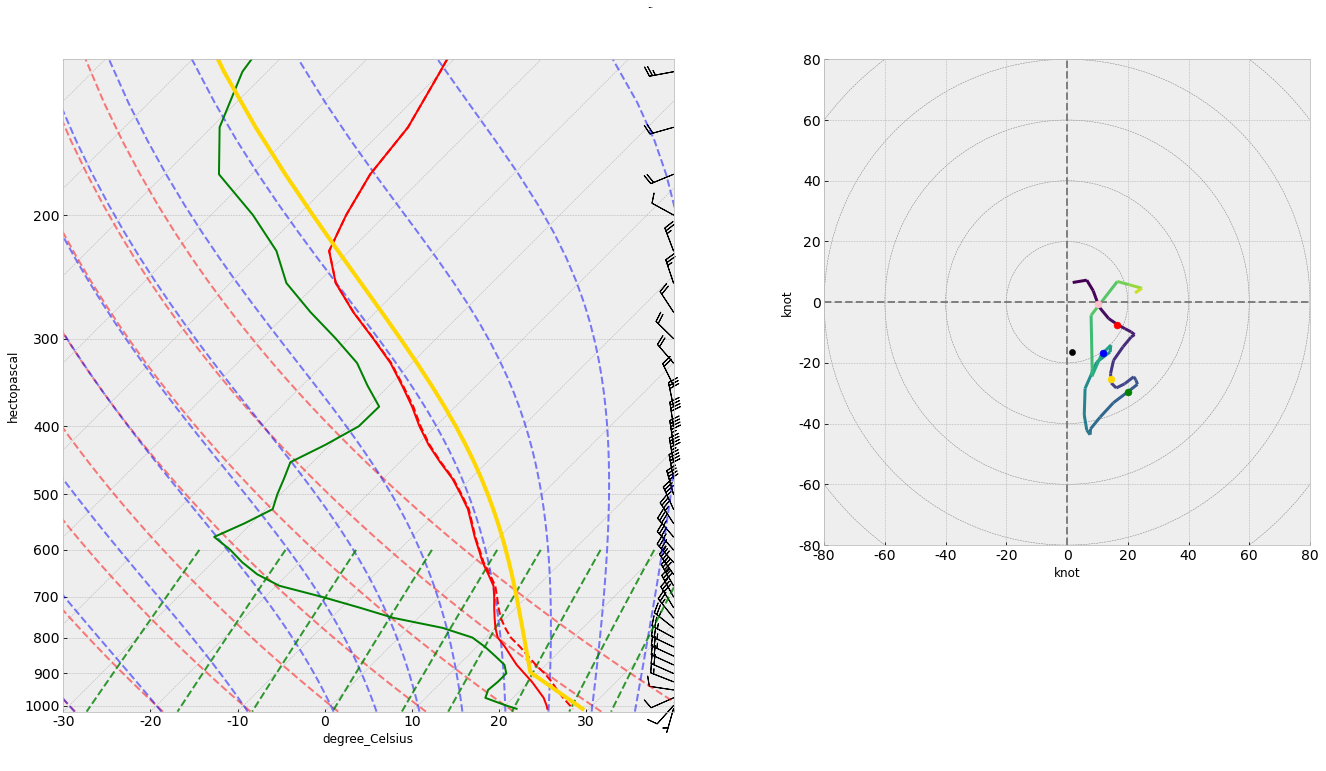

In [242]:
#%matplotlib inline
plt.style.use('bmh')
#plt.title('21 UTC NARR Sounding 31 May 1985 Wheatland, PA')
# Change default to be better for skew-T
fig = plt.figure(figsize=(24, 12))
#skew = SkewT(fig)
gs = gridspec.GridSpec(8, 4)
skew = SkewT(fig, rotation=45, subplot=gs[:, :2])
skew.plot(p_skewt, T_skewt, 'r')
skew.plot(p_skewt, vtemp_pr[::-1], 'r', linestyle='--')
skew.plot(p_skewt, Td_skewt, 'g')
skew.plot_barbs(p_skewt, u_skewt, v_skewt)

#profile1 = metcalc.parcel_profile(p_skewt[::-1], T_skewt[::-1], Td_skewt[::-1]).to('degC')
#Plot the most unstable parcel path
#skew.plot(pres_mu, mu_profile, 'orange', linewidth=4, linestyle = '--')
#Plot the parcel path
skew.plot(pprofile1, profile1, 'gold', linewidth=4)


#Let's try to fill between the profile and parcel path.
#greater = Tc >= prof
#skew.ax.fill_betweenx(levc, Tc, prof, where=greater, facecolor='blue', alpha=0.4)
#skew.ax.fill_betweenx(levc, Tc, prof, where=~greater, facecolor='red', alpha=0.4)

skew.ax.set_ylim(1020, 120)
# Good bounds for aspect ratio
skew.ax.set_xlim(-30, 40)
skew.ax.set_xticklabels([-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30], size = 14)
skew.ax.set_yticklabels([100,200,300,400,500,600,700,800,900,1000],size = 14)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

ax1 = fig.add_subplot(gs[:6, 2:])
h = Hodograph(ax1,component_range=80.)
h.add_grid(increment=20)
c = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1]-hgt_skewt[-1])
#cl = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1], bounds = [0, 1000, 3000, 5000, 10000] * units('meter'),
#             colors = ['magenta', 'red', 'yellow', 'green'], linewidth = 4)
#cl = h.plot_colormapped(u_skewt[::-1], v_skewt[::-1], np.asarray(hgt_skewt[::-1]), bounds = np.asarray([0, 1000, 3000, 5000, 10000]) * units('meter'), colors = ['magenta', 'red', 'yellow', 'green'], linewidth = 4)
#Interpolate the wind levels
hgt_points = metinterp([500, 1000, 3000, 5000, 10000]*units('meter'),hgt_skewt[::-1]-hgt_skewt[-1], u_skewt[::-1], v_skewt[::-1])
h.ax.scatter(storm_motion[0][0].to('knots'), storm_motion[0][1].to('knots'), s = 38, color = 'k')
h.ax.scatter(hgt_points[0][0], hgt_points[1][0], s = 48, color = 'pink', zorder=10)
h.ax.scatter(hgt_points[0][1], hgt_points[1][1], s = 48, color = 'r', zorder=10)
h.ax.scatter(hgt_points[0][2], hgt_points[1][2], s = 48, color = 'gold', zorder=10)
h.ax.scatter(hgt_points[0][3], hgt_points[1][3], s = 48, color = 'green', zorder=10)
h.ax.scatter(hgt_points[0][4], hgt_points[1][4], s = 48, color = 'blue', zorder=10)

#cb = plt.colorbar(cl, shrink = .8)
#cb.ax.set_yticklabels(['sfc','1,000','3,000','5,000','10,000'])
#cb.set_label('Height AGL (m)')
h.ax.set_xticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
h.ax.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
plt.savefig('RandomSounding.png')
plt.show()

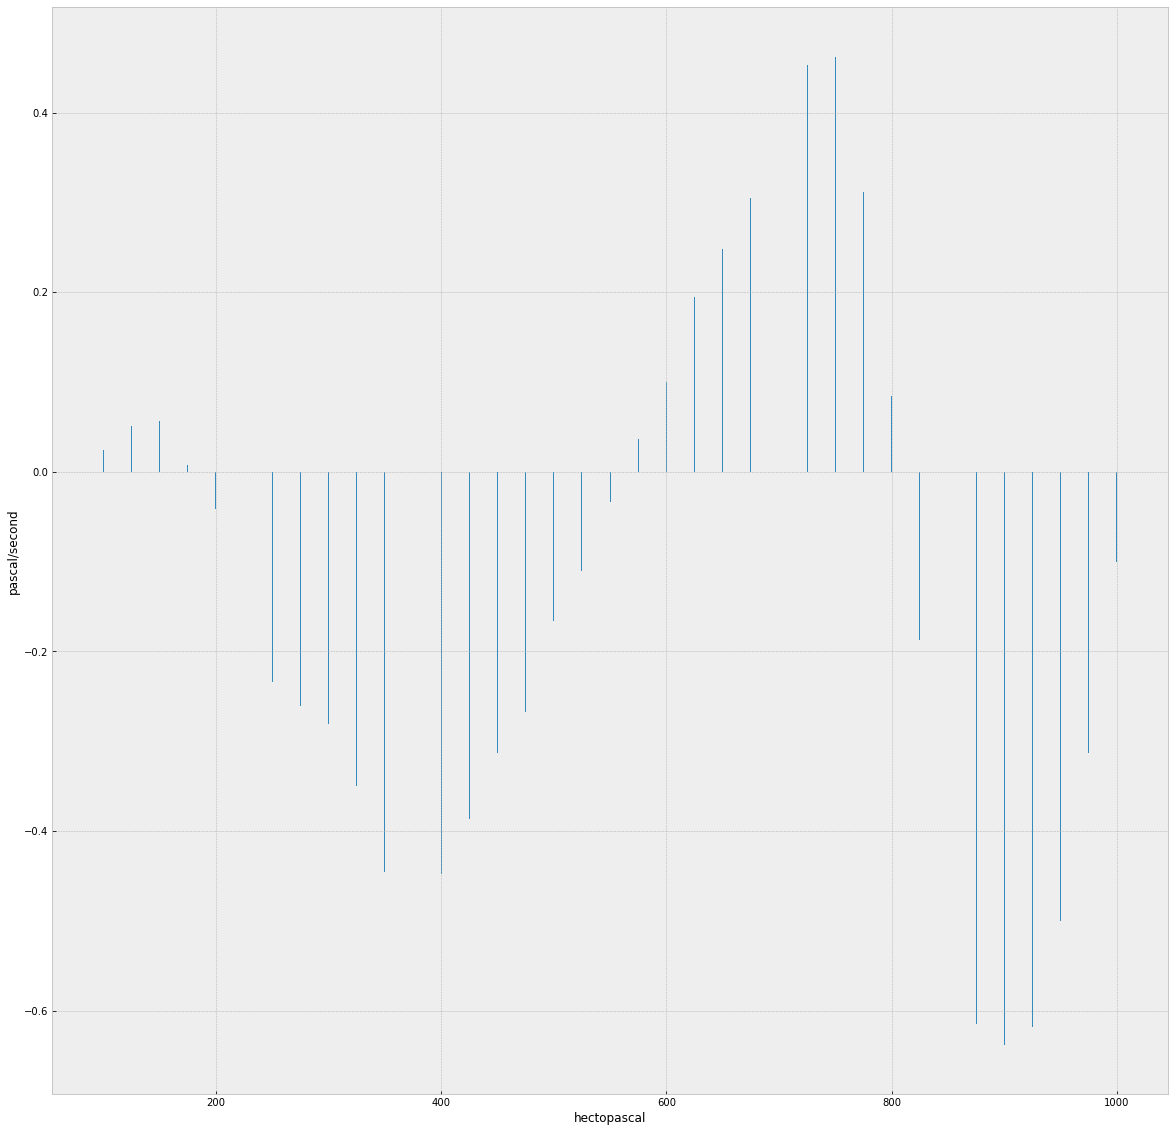

In [243]:
fig=plt.figure(2,figsize=(20.,20.))
plt.bar(lev, Omega)
plt.show()

In [244]:
#############################################
#The cells below will save the sounding and its parameters to a csv if you want to have the data available.

In [245]:
print([site, year, month, day, hour, tor_nontor, mlcape, lcl, lfc, mucape, cin, effective_srh, ebwspd, scp, sigtor, rh3, rh6, rh9, p3km, p6km, p9km, mpwrh_13, mpwrh_36, mpwrh_69, hgt0c, cclt, lclt, srh1km, srh3km, sfc1shear, sfc3shear, sfc6shear, EHI, cenlat, cenlon])

['KLCH', 2020, '05', 17, 23, 'T', 1093.2030159165427, 1037.9443213985242, 1544.0513002165894, 2273.7471797356466, -26.888715544281837, 141.129035755745, 25.177307043751696, 6.417834940568729, 1.7717683705777274, 0.26451765246271375, 0.17441506548864427, 0.6829366858163197, 709.3897515046, 486.24888563031635, 323.2482790773883, 0.7179923843395126, 0.13467186713254453, 0.44484189161879834, 4200.72600058554, 18.273384025827326, 18.273384025827326, 116.88425958490153, 203.09220323518517, 20.231846836439082, 34.30680072056542, 47.006459859071796, 1.2152489217172335, 29.758, -93.556]


In [246]:
#Save the whole sounding to a pickle file
#Save pressure, height, temperature, dewpoint, u, and v
sounding_array = np.zeros((6, len(p_skewt)))
sounding_array[0,:]=p_skewt
sounding_array[1,:]=hgt_skewt
sounding_array[2,:]=T_skewt
sounding_array[3,:]=Td_skewt
sounding_array[4,:]=u_skewt
sounding_array[5,:]=v_skewt
#Save to pickle
with open('SupercellSoundingsNew/sounding'+str(site)+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z.pkl', 'wb') as f:
    pickle.dump(sounding_array, f)
    
#Write environmental parameters to csv
with open('SupercellSoundingsNew/environment_2020.csv', mode='a') as env_file:
    env_writer = csv.writer(env_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    env_writer.writerow([site, year, month, day, hour, tor_nontor, mlcape, lcl, lfc, mucape, cin, effective_srh, ebwspd, scp, sigtor, rh3, rh6, rh9, p3km, p6km, p9km, mpwrh_13, mpwrh_36, mpwrh_69, hgt0c, cclt, lclt, srh1km, srh3km, sfc1shear, sfc3shear, sfc6shear, EHI, cenlat, cenlon])

In [247]:
print(hgt_skewt-hgt_skewt[-1])

[16541.509765625 15162.7578125 14018.341796875 13043.4560546875 12193.4755859375 11436.67578125 10749.6904296875 10115.1416015625 9520.6552734375 8962.2998046875 8435.98828125 7938.49462890625 7467.12548828125 7018.89306640625 6589.71728515625 6179.56787109375 5786.048828125 5406.78173828125 5043.94775390625 4692.42822265625 4355.52099609375 4028.10107421875 3712.923828125 3406.052978515625 3109.376953125 2821.328125 2541.59033203125 2270.00830078125 2005.06298828125 1746.552001953125 1494.175048828125 1247.436279296875 1005.9572143554688 769.52783203125 538.0599365234375 311.3643798828125 88.5776596069336 0.0] meter


In [248]:
print(T_skewt)

[-63.59275817871094 -60.155120849609375 -57.47157287597656 -56.41670227050781 -54.50250244140625 -52.34027099609375 -47.902130126953125 -42.56126403808594 -37.230621337890625 -32.44746398925781 -28.521026611328125 -24.968612670898438 -21.866729736328125 -18.699661254882812 -15.37445068359375 -12.0770263671875 -9.331817626953125 -6.798187255859375 -4.768341064453125 -2.840850830078125 -0.8782958984375 0.979461669921875 3.00579833984375 4.918975830078125 6.2723388671875 7.496795654296875 8.731292724609375 9.967376708984375 11.34765625 13.256103515625 14.970428466796875 16.653106689453125 18.520782470703125 20.3458251953125 21.96307373046875 23.53271484375 24.752288818359375 25.201202392578125] degree_Celsius


In [206]:
print(Td_skewt)

[-84.99871063232422 -83.62142181396484 -78.18561553955078 -72.17899322509766 -65.99567413330078 -60.594425201416016 -55.4675178527832 -49.88914489746094 -45.22447967529297 -41.9909782409668 -38.95326614379883 -36.170169830322266 -32.888587951660156 -29.744272232055664 -26.707162857055664 -23.072664260864258 -19.279216766357422 -15.034337043762207 -11.329944610595703 -8.193294525146484 -5.463944435119629 -3.005284070968628 -0.7851594686508179 1.2102497816085815 3.104506492614746 5.292364597320557 7.261262893676758 8.716856002807617 9.646417617797852 10.481051445007324 11.675192832946777 12.456149101257324 13.761871337890625] degree_Celsius


In [ ]:
import numpy

In [ ]:
numpy.version.version

In [ ]:
print(srwind)